In [1]:
import numpy as np
import pandas as pd
from dit.pid import *
from itertools import product
import matplotlib.pyplot as plt
import dit 

%matplotlib inline
%config InlineBackend.figure_format='retina'


### NOTE: this notebook requires the output of the script `music_redundancy_calculation.py`

In [2]:
def mutInf(prob_dict, vars1, vars2):
    '''
    prob_dict is a dict that maps strings to floats
    vars1 and vars2 are lists of integer indices
    '''
    mi=0

    comb_marginal = {}
    for state, prob in prob_dict.items():
        state_comb = ''.join([state[i] for i in list(vars1)+list(vars2)])
        comb_marginal[state_comb] = comb_marginal.get(state_comb, 0) + prob
    
    marginal1 = {}
    marginal2 = {}
    for state, prob in comb_marginal.items():
        state1 = ''.join(state[:len(vars1)])
        state2 = ''.join(state[len(vars1):])
        marginal1[state1] = marginal1.get(state1, 0) + prob
        marginal2[state2] = marginal2.get(state2, 0) + prob

    for state, prob in comb_marginal.items():
        state1 = ''.join(state[:len(vars1)])
        state2 = ''.join(state[len(vars1):])
        if prob == 0:
            continue
        mi += prob * np.log2(prob/(marginal1[state1]*marginal2[state2]))
    return mi


def Immi_ditless(d, sources, targets):
    return min([mutInf(d, source, target) for source, target in product(sources, targets)])

def acStringToTuple(ac):
    return tuple([tuple([int(x) for x in block]) for block in ac.split('|')])

def acTupleToString(ac):
    return '|'.join([''.join([str(x) for x in block]) for block in ac])

def acTupleToVoice(ac):
        return tuple(tuple(voices[i] for i in block) for block in ac)

def compute_mobius_inversion(redsDict,  mfMat):
    atoms, reds = list(zip(redsDict.items()))
    return dict(list(zip(atoms, np.dot(reds, mfMat))))

def constructDist(data, delay):
    pairedData = np.array([np.hstack([data[i], data[i+delay]]) for i in range(len(data)-delay)])
    states, counts = np.unique(pairedData.astype(str), axis=0, return_counts=True)
    pmf = {''.join(state): count/len(pairedData) for state, count in zip(states, counts)}
    return pmf

def calc_immi_ditless(args):
    d, ac1, ac2 = args
    return acTupleToString(ac1), acTupleToString(ac2), Immi_ditless(d, ac1, ac2)

In [17]:
N = 4
composer = 'bach'
delay = 1
mood = 'major'
shuffled = False

mfMat = pd.read_csv(f'FMT_outputs/antiChainLattice_mobiusFns_N={N}.csv', index_col=0)
acs_t = [acStringToTuple(x) for x in (mfMat.columns)]
acs_tp1 = [tuple(tuple(e+N for e in a) for a in ac) for ac in acs_t]

if shuffled:
    music = pd.read_csv(f'musicData/{composer}_{mood}_shuffled.csv', index_col=0)
else:
    music = pd.read_csv(f'musicData/{composer}_{mood}.csv', index_col=0)

# Keep only the chords that are different from the previous one
music = music.loc[(music.shift() != music).any(axis=1)]

d = constructDist(music.values[:, :N], delay)
voices = ['S', 'A', 'T', 'B', 's', 'a', 't', 'b']

mu_pid = mfMat.values
mu_phi = np.kron(mu_pid, mu_pid)

acProduct = [','.join(x) for x in list(product([acTupleToString(a) for a in acs_t], [acTupleToString(a) for a in acs_tp1]))]
mu_phi_df = pd.DataFrame(mu_phi, index=acProduct, columns=acProduct)

def acTupleToVoice(ac):
    return tuple(tuple(voices[i] for i in block) for block in ac)

In [18]:
piDict = {}

for composer in ['corelli', 'bach']:
    for mood in ['major']:
        for delay in [1, 5, 10, 100]:
            for shuffled in ['', '_shuffled']:
                try:
                    # calculated in about 5 minutes with music_redundancy_calculation.py
                    reds = pd.read_csv(f'musicData/reds_{composer}_{mood}_N{N}_delay{delay}{shuffled}.csv', index_col=0)
                    # That this is the right transposition can be seen by looking at the value of the top element
                    # mu_phi_df.loc['0123,0123'].values @ reds
                    # This should be a sum of many, not of just one element
                    pis = mu_phi_df.T @ reds
                    pis.index = [x.replace('0','S').replace('1', 'A').replace('2', 'T').replace('3', 'B').replace('4','S').replace('5', 'A').replace('6', 'T').replace('7', 'B') for x in pis.index]
                    piDict[f'{composer}_{mood}_N{N}_delay{delay}{shuffled}'] = pis
                    
                except FileNotFoundError:
                    pass
                


In [19]:
def sepDynamics(piDict):
    # causUp: any atom where the max source is smaller than the single target
    causUp = piDict.iloc[[(len(s.split(',')[1].split('|'))==1) and max([len(e) for e in s.split(',')[0].split('|')]) < max([len(e) for e in s.split(',')[1].split('|')]) for s in piDict.index]].values.flatten()

    # causDown: any atom where the single source is larger than the max target
    causDown = piDict.iloc[[(len(s.split(',')[0].split('|'))==1) and max([len(e) for e in s.split(',')[0].split('|')]) > max([len(e) for e in s.split(',')[1].split('|')]) for s in piDict.index]].values.flatten()

    # storage: any atom where the source and target are the same
    storage = piDict.iloc[[s.split(',')[0] == s.split(',')[1] for s in piDict.index]].values.flatten()

    # transfer: any atom where the source and target are both of size 1 but different
    transfer = piDict.iloc[[(len(s.split(',')[0].split('|'))==1) & (len(s.split(',')[1].split('|'))==1) & (s.split(',')[0]!=s.split(',')[1]) for s in piDict.index]].values.flatten()

    # copy: any atom where the source is a subset of the target
    copy = piDict.iloc[[(s.split(',')[0] in s.split(',')[1].split('|')) & (s.split(',')[0] != s.split(',')[1]) for s in piDict.index]].values.flatten()

    # erasure: any atom where the target is a subset of the source
    erasure = piDict.iloc[[(s.split(',')[1] in s.split(',')[0].split('|')) & (s.split(',')[0] != s.split(',')[1]) for s in piDict.index]].values.flatten()

    return {'Upward Causality': causUp, 'Downward Causality': causDown, 'Storage': storage, 'Transfer': transfer, 'Copy': copy, 'Erasure': erasure}

/var/folders/cx/91ysy22n5q1bw76k3h1v0f280000gp/T/ipykernel_46888/1149289855.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


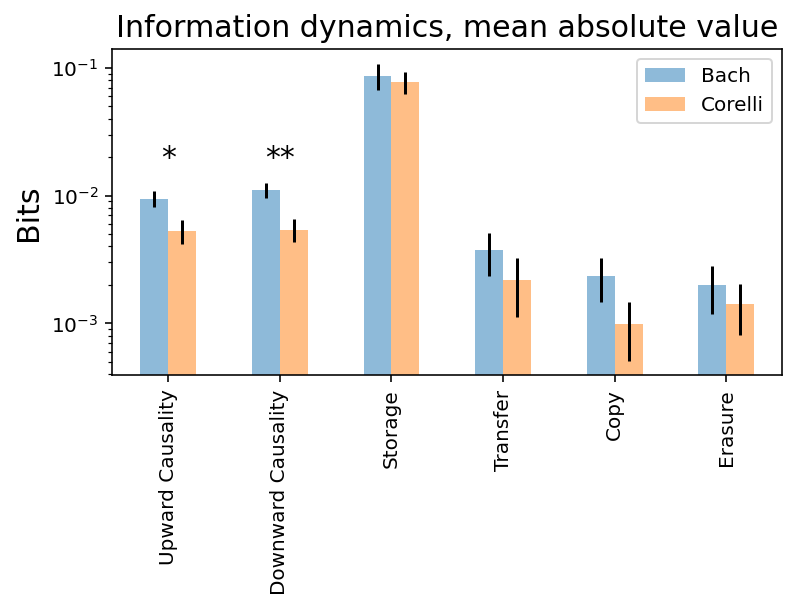

In [20]:
catA = 'Bach'
catB = 'Corelli'

fig, ax = plt.subplots(1, 1, figsize=(6, 3))


# NOW JUST THE ABSOLUTE VALUES
d1 = sepDynamics(piDict['bach_major_N4_delay1'].abs() - piDict['bach_major_N4_delay1_shuffled'].abs())
d2 = sepDynamics(piDict['corelli_major_N4_delay1'].abs() - piDict['corelli_major_N4_delay1_shuffled'].abs())
keys = d2.keys()

df = pd.DataFrame({key: [np.mean(d1[key]), np.std(d1[key])/np.sqrt(len(d1[key])), np.mean(d2[key]), np.std(d2[key])/np.sqrt(len(d2[key]))] for key in keys})
df.index = [catA, 'A_stderr', catB, 'B_stderr']
df = df.T
yerr = df[['A_stderr', 'B_stderr']].to_numpy().T

df[[catA, catB]].plot(kind='bar', yerr=yerr, alpha=0.5, error_kw=dict(ecolor='k'), ax=ax)
ax.set_title(f'Information dynamics, mean absolute value', fontsize=15)

ax.set_yscale('log')
ax.set_ylabel('Bits', fontsize=15)
ax.text(ax.get_xticks()[0], 0.015, '*', ha='center', va='bottom', fontsize=15)
ax.text(ax.get_xticks()[1], 0.015, '**', ha='center', va='bottom', fontsize=15)
fig.show()

In [23]:
from scipy.stats import ttest_ind, ks_2samp, ttest_rel, median_test
for key in d1.keys():
    print(key)
    A = sepDynamics(piDict['bach_major_N4_delay1'].abs() - piDict['bach_major_N4_delay1_shuffled'].abs())[key]
    B = sepDynamics(piDict['corelli_major_N4_delay1'].abs() - piDict['corelli_major_N4_delay1_shuffled'].abs())[key]
    print(ttest_ind(A, B)[1], len(A), len(B))

Upward Causality
0.017207424665217103 703 703
Downward Causality
0.0018589628753988066 703 703
Storage
0.7169289130724131 166 166
Transfer
0.3717417190644585 210 210
Copy
0.18068396781356239 438 438
Erasure
0.5675429313107665 438 438


/var/folders/cx/91ysy22n5q1bw76k3h1v0f280000gp/T/ipykernel_46888/3782393689.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


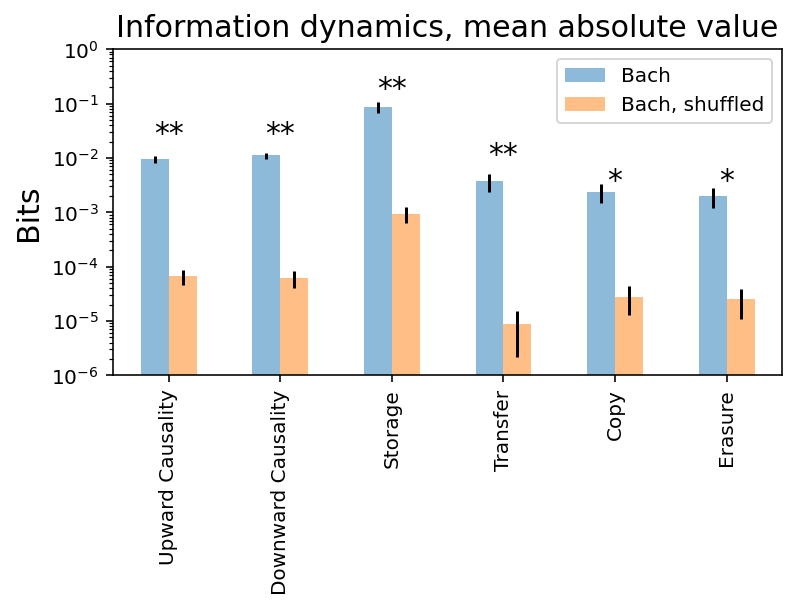

In [24]:
catA = 'Bach'
catB = 'Bach, shuffled'

fig, ax = plt.subplots(1, 1, figsize=(6, 3))


# NOW JUST THE ABSOLUTE VALUES
d1 = sepDynamics(piDict['bach_major_N4_delay1'].abs())
d2 = sepDynamics(piDict['bach_major_N4_delay1_shuffled'].abs())
keys = d2.keys()

df = pd.DataFrame({key: [np.mean(d1[key]), np.std(d1[key])/np.sqrt(len(d1[key])), np.mean(d2[key]), np.std(d2[key])/np.sqrt(len(d2[key]))] for key in keys})
df.index = [catA, 'A_stderr', catB, 'B_stderr']
df = df.T
yerr = df[['A_stderr', 'B_stderr']].to_numpy().T

df[[catA, catB]].plot(kind='bar', yerr=yerr, alpha=0.5, error_kw=dict(ecolor='k'), ax=ax)
ax.set_title(f'Information dynamics, mean absolute value', fontsize=15)

ax.set_ylim(1e-6, 1)

ax.set_yscale('log')
ax.set_ylabel('Bits', fontsize=15)
ax.text(ax.get_xticks()[0], 0.015, '**', ha='center', va='bottom', fontsize=15)
ax.text(ax.get_xticks()[1], 0.015, '**', ha='center', va='bottom', fontsize=15)
ax.text(ax.get_xticks()[2], 0.1, '**', ha='center', va='bottom', fontsize=15)
ax.text(ax.get_xticks()[3], 0.006, '**', ha='center', va='bottom', fontsize=15)
ax.text(ax.get_xticks()[4], 0.002, '*', ha='center', va='bottom', fontsize=15)
ax.text(ax.get_xticks()[5], 0.002, '*', ha='center', va='bottom', fontsize=15)

fig.show()

In [26]:
from scipy.stats import ttest_ind
for key in d1.keys():
    print(key)
    A = sepDynamics(piDict['bach_major_N4_delay1'].abs())[key]
    B = sepDynamics(piDict['bach_major_N4_delay1_shuffled'].abs())[key]
    print(ttest_ind(A, B)[1], len(A), len(B))


Upward Causality
6.498820088242375e-12 703 703
Downward Causality
3.8926906553082384e-14 703 703
Storage
2.877599336233273e-05 166 166
Transfer
0.007318804780765516 210 210
Copy
0.00869257855684805 438 438
Erasure
0.014597431554036894 438 438
